<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Analysis of the Agatha Christie corpus
</p><br>
Model for NLP analysis: Datacamp "Book Recommendations from Charles Darwin" by Philippe Julien

### Scrape corpus
https://archive.org/details/agathachristie/page/n5

In [1]:
#Scrape titles from html
from bs4 import BeautifulSoup
import requests
url='https://archive.org/details/agathachristie/'
soup_titles = BeautifulSoup(requests.get(url).content,'html.parser')

In [3]:
titles_w_path=[title['href'] for div in soup_titles.find_all('div',{'class':"jwrowV2"}) for title in div('a')]
len(titles_w_path)

154

In [4]:
titles_w_path[:] = [x for x in titles_w_path if not '/%D8%B9%D8%B1%D8%A8%D9%89/' in x]
len(titles_w_path)

60

In [5]:
titles_w_path[0]

'/stream/agathachristie/Agatha%20Christie/English/Agatha%20Christie%20-%204.50%20from%20Paddington'

In [17]:
relative_path_to_files='/stream/agathachristie/Agatha%20Christie/English/Agatha%20Christie%20-%20'
titles=[x.replace(relative_path_to_files,'').replace('%20','') for x in titles_w_path]
titles

['4.50fromPaddington',
 'ACaribbeanMystery',
 'APocketFullofRye',
 'AfterTheFuneral',
 'AppointmentWithDeath',
 'AtBertram%27sHotel',
 'BythePrickingofMyThumbs',
 'CardsontheTable',
 'CatAmongthePigeons',
 'DeathComesAsEnd',
 'DeathontheNile',
 'Dumbwitness',
 'ElephantsCanRemember',
 'English-MurderIsEasy',
 'EvilUndertheSun',
 'HalloweenParty',
 'HerculePoirot%27sCasebook',
 'HerculePoirot%27sChristmas',
 'HickoryDickoryDeath',
 'LordEdgwareDies',
 'MurderinMesopotamia',
 'MurderintheMews',
 'MurderontheLinks',
 'MurderontheOrientExpress',
 'MysteriousMrQuin',
 'Nemesis',
 'OneTwoBuckleMyShoe',
 'OrdealByInnocence',
 'ParkerPyneInvestigates',
 'PartnersinCrime',
 'PoirotLosesaClient',
 'Poirot%27sEarlyCases',
 'SadCypress',
 'SleepingMurder',
 'TheABCMurders',
 'TheAdventureofChristmasPudding',
 'TheBigFour',
 'TheCircularStaircase',
 'TheClocks',
 'TheGoldenBall',
 'TheHarlequinTeaSetAndOtherStories',
 'TheHollow.',
 'TheLaboursOfHercules',
 'TheListerdaleMysteryandOtherStories',
 '

In [18]:
exception='/stream/agathachristie/AgathaChristie/English/Christie_Agatha-'
titles=[x.replace(exception,'').replace('%27','') for x in titles]
titles[-2:]

['WhyDidntTheyAskEvans', 'MurderInThreeActs']

In [19]:
import os
try:
    os.mkdir('agatha_christie_corpus')
except FileExistsError:
    print("The directory",'agatha_christie_corpus',"already exists")
abs_url='https://archive.org'

The directory agatha_christie_corpus already exists


In [50]:
#Collect texts and store them as .txt
def finished(num_tries=0):
    return num_tries == 3
def store_texts(urlname,title):
    num_tries = 0
    while not finished():
        soup_content = BeautifulSoup(requests.get(f'{abs_url}{urlname}_djvu.txt').content,'html.parser')
        try:
            with open(f'agatha_christie_corpus/{title}.txt', 'w',encoding='gb18030') as f:
                txt=soup_content.pre.get_text()
                f.write(txt)
            return txt
        except ValueError:
            num_tries += 1
            if not finished(num_tries):
                print("Event URL failed. Will retry...")
    raise RuntimeError("Error: Event URL failed.")

In [51]:
texts=[]
for (urlname,title) in zip(titles_w_path,titles):
    texts.append(store_texts(urlname,title))

In [53]:
texts[0][0:30]

'\n4:50 from Paddington \n\nBook J'

### Tokenize, Stemming, bag-of-words

In [61]:
#Tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

texts_tokenized=[]
for text in texts:
    tokens=[w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops=[t for t in tokens if t not in stopwords.words('english')]
    texts_tokenized.append(no_stops)

Difference between stemming and lemmatization: the object of stemmers is not to find the root word (or lemmatization), but rather find a shortened version of the word that other inflections would also shorten to.

In [63]:
import pickle
output = open('texts_tokenized.pkl', 'wb')
pickle.dump(texts_tokenized, output)
output.close()

In [ ]:
#Stemming
from nltk import PorterStemmer
stemmer=PorterStemmer()

text_stemmed=[]
for text in texts_tokenized:
    text_stemmed.append([stemmer.stem(word) for word in text])

In [107]:
text_stemmed[0][0:10]

['paddington',
 'book',
 'jacket',
 'none',
 'tag',
 'mysteri',
 'detect',
 'gener',
 'mysteri',
 'mysteri']

In [108]:
output = open('texts_stemmed.pkl', 'wb')
pickle.dump(texts_stemmed, output)
output.close()

Bag of word using either collection.Counter or the gensim library.
Advantages of gensim:
- Gensim model can be easily saved, updated, and reused
- the corpora dictionary lists an index for the words together with their count: useful for statistical analyses (similarity matrix, tf-idf), we can add back the word corresponding to each indice afterwards for human reading.

In [128]:
#bag-of-words using collection.Counter. 
from collections import Counter #https://docs.python.org/2/library/collections.html
bow=[]
for text in text_stemmed:
    bow.append(Counter(text))
bow[1].most_common(10)

[('said', 713),
 ('miss', 556),
 ('marpl', 495),
 ('know', 250),
 ('think', 245),
 ('look', 231),
 ('one', 216),
 ('rafter', 195),
 ('molli', 178),
 ('well', 175)]

In [131]:
from gensim import corpora
dictionary = corpora.Dictionary(text_stemmed)
bows = [dictionary.doc2bow(doc) for doc in text_stemmed]
bows[1][0:5]

[(0, 5), (1, 2), (3, 6), (4, 1), (6, 4)]

In [132]:
import pandas as pd
df_bow_origin = pd.DataFrame(bows[1])
df_bow_origin.columns=['index','occurrences']
dict_tokens=(dict((v,k) for k,v in dictionary.token2id.items()))
df_bow_origin['token']=df_bow_origin['index'].apply(lambda x: dict_tokens[x])

df_bow_origin=df_bow_origin.sort_values('occurrences',ascending=False)
df_bow_origin.head(10)

,index,occurrences,token
1472,3011,713,said
1086,2239,556,miss
1047,2161,495,marpl
952,1970,250,know
1750,3555,245,think
1015,2085,231,look
1195,2423,216,one
2754,4770,195,rafter
2595,4611,178,molli
1879,3860,175,well


### tf-idf and similarity matrix
Find words that stand out in a text relative to other documents & find distance between documents

In [134]:
from gensim.models import TfidfModel
model = TfidfModel(bows)
df_tfidf = pd.DataFrame(model[bows[1]])
df_tfidf.columns=['id','score']
df_tfidf['token']=df_tfidf['id'].apply(lambda x: dict_tokens[x])
df_tfidf=df_tfidf.sort_values('score',ascending=False)
df_tfidf.head()

,id,score,token
2752,4770,0.440704,rafter
1046,2161,0.392040,marpl
2676,4694,0.361393,palgrav
2422,4440,0.299617,hillingdon
2514,4532,0.274906,kendal


In [135]:
from gensim import similarities
sims = similarities.MatrixSimilarity(model[bows])
sim_df = pd.DataFrame(list(sims))
sim_df.columns=titles
sim_df.index=titles
sim_df

,4.50fromPaddington,ACaribbeanMystery,APocketFullofRye,AfterTheFuneral,AppointmentWithDeath,AtBertramsHotel,BythePrickingofMyThumbs,CardsontheTable,CatAmongthePigeons,DeathComesAsEnd,...,TheMysteriousMr.Quin,TheMysteryoftheBlueTrain,ThePerilatEndHouse,TheSecretAdversary,TheSittafordMystery,ThirdGirl,ThreeActTragedy,TowardsZero,WhyDidntTheyAskEvans,MurderInThreeActs
4.50fromPaddington,1.000000,0.065815,0.015287,0.002582,0.001445,0.032208,0.006042,0.017710,0.003033,0.000522,...,0.002531,0.002653,0.003177,0.002536,0.003773,0.003820,0.002785,0.002319,0.001070,0.001601
ACaribbeanMystery,0.065815,1.000000,0.032451,0.011911,0.002236,0.082426,0.006542,0.003505,0.003281,0.000561,...,0.007072,0.002226,0.009287,0.001552,0.006149,0.002946,0.002371,0.002348,0.000786,0.001703
APocketFullofRye,0.015287,0.032451,1.000000,0.001550,0.000892,0.017948,0.001654,0.001408,0.007843,0.000339,...,0.001134,0.001544,0.003136,0.001011,0.004138,0.039772,0.001987,0.001453,0.000665,0.001084
AfterTheFuneral,0.002582,0.011911,0.001550,0.999999,0.005806,0.007916,0.003940,0.012613,0.004859,0.000537,...,0.004219,0.011308,0.022455,0.001771,0.011403,0.015006,0.006528,0.001897,0.001185,0.004800
AppointmentWithDeath,0.001445,0.002236,0.000892,0.005806,1.000000,0.002475,0.001878,0.010896,0.005982,0.000542,...,0.006680,0.010267,0.022461,0.001165,0.002775,0.014055,0.005512,0.001101,0.000586,0.003877
AtBertramsHotel,0.032208,0.082426,0.017948,0.007916,0.002475,1.000000,0.004661,0.003413,0.007439,0.000661,...,0.002798,0.013811,0.006429,0.003283,0.007209,0.004504,0.004463,0.003681,0.001198,0.002251
BythePrickingofMyThumbs,0.006042,0.006542,0.001654,0.003940,0.001878,0.004661,1.000001,0.005245,0.006123,0.000731,...,0.003049,0.008580,0.004102,0.544980,0.004375,0.003523,0.002930,0.004343,0.003924,0.001781
CardsontheTable,0.017710,0.003505,0.001408,0.012613,0.010896,0.003413,0.005245,1.000000,0.013932,0.000693,...,0.001656,0.017153,0.036048,0.003061,0.005829,0.046280,0.015742,0.025800,0.001255,0.010993
CatAmongthePigeons,0.003033,0.003281,0.007843,0.004859,0.005982,0.007439,0.006123,0.013932,1.000000,0.000971,...,0.002482,0.010934,0.018742,0.002374,0.011751,0.011491,0.017247,0.003163,0.001059,0.011420
DeathComesAsEnd,0.000522,0.000561,0.000339,0.000537,0.000542,0.000661,0.000731,0.000693,0.000971,1.000000,...,0.000510,0.000566,0.000989,0.000587,0.000557,0.000952,0.000580,0.000473,0.000256,0.000387


Text(0, 0.5, 'frequency')

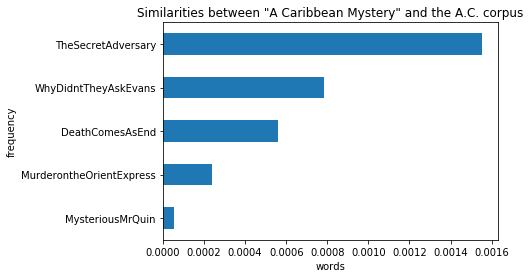

In [138]:
%matplotlib inline

import matplotlib.pyplot as plt
v = sim_df['ACaribbeanMystery']
v_sorted = v.sort_values()[0:5]
v_sorted.plot.barh()

plt.title('Similarities between "A Caribbean Mystery" and the A.C. corpus (4 most similar works)')
plt.xlabel('words')
plt.ylabel('frequency')

Reference on the hierarcy.dendrogram: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

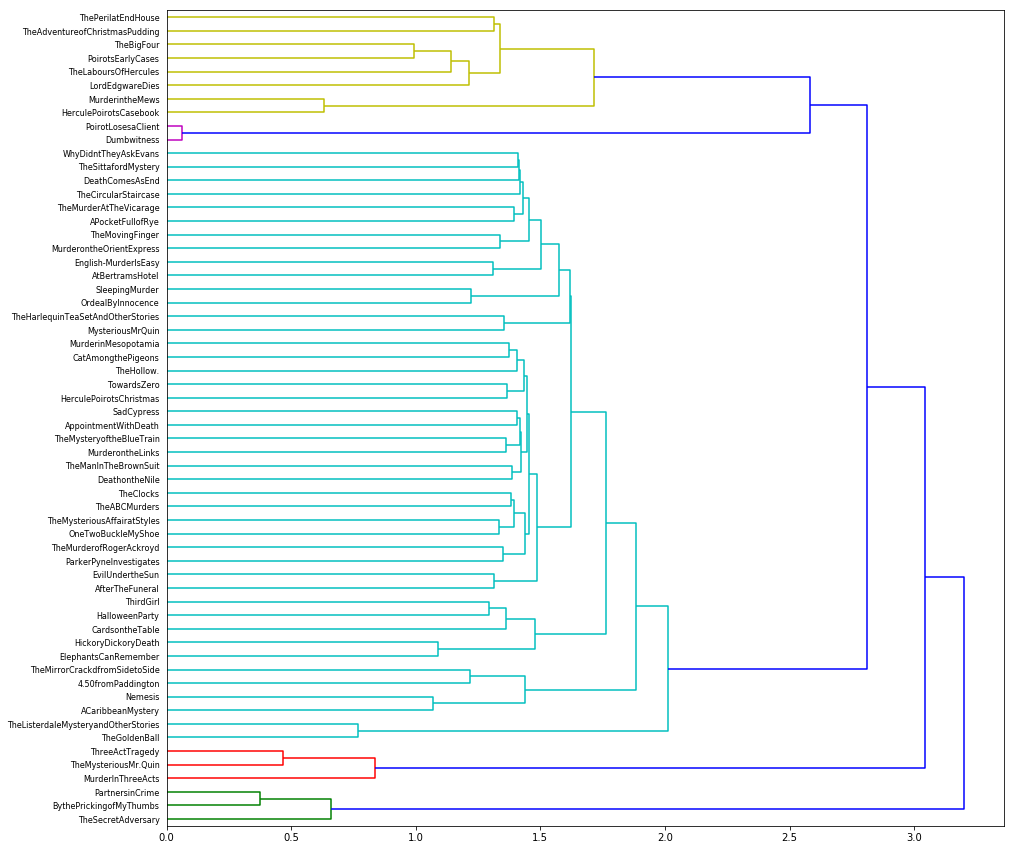

In [160]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(sims, 'ward') # using the Ward variance minimization algorithm
plt.figure(figsize=(15,15))
a=hierarchy.dendrogram(Z, orientation='right', leaf_font_size=8,labels=titles)